In [1]:
import transformers
import PIL
import torch
import diffusers
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

/home/ubuntu/.local/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [2]:
pipe_prior = diffusers.KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
).to("cuda")
pipe = diffusers.KandinskyV22Pipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16).to("cuda")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.2.0+cu118)
    Python  3.8.18 (you have 3.8.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# pipe.scheduler = diffusers.EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = diffusers.DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

In [4]:
# img1 = PIL.Image.open("stage.jpeg")
# img2 = PIL.Image.open("stage2.jpeg")

# add all the conditions we want to interpolate, can be either text or image
prompt = "epic bottle of tobasco sauce"
images_texts = [prompt, prompt]

w = 0.4
weights = [w, 1 - w]

# We can leave the prompt empty
prompt = ""
prior_out = pipe_prior.interpolate(images_texts, weights)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [5]:
h = 1024
w = 1024
guidance_scale = 5.0
image = pipe(**prior_out, height=h, width=w, num_inference_steps=25, guidance_scale=guidance_scale).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [6]:
prior_out.keys()

odict_keys(['image_embeds', 'negative_image_embeds'])

In [7]:
embeds = torch.load("embeds.pt")

In [8]:
embeds.shape

torch.Size([188607, 1280])

In [9]:
# get pca
embeds = embeds.cuda()

mean = torch.mean(embeds, dim=0)
centered_data = embeds - mean
covariance_matrix = torch.cov(centered_data.T)
U, S, V = torch.linalg.svd(covariance_matrix, full_matrices=False)
pc_embeds = V
pc_scale = S


Text(0, 0.5, 'Value')

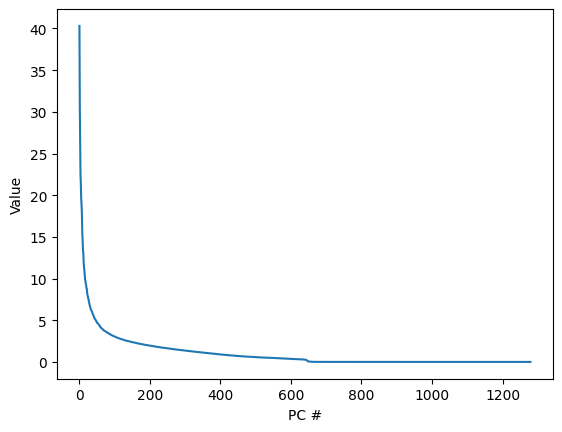

In [10]:
plt.plot(S.cpu())
plt.xlabel("PC #")
plt.ylabel("Value")

Text(0, 0.5, 'Log Value')

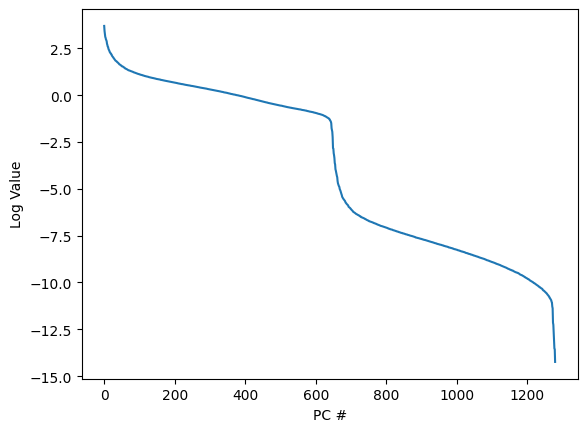

In [11]:
plt.plot(torch.log(S.cpu()))
plt.xlabel("PC #")
plt.ylabel("Log Value")

In [12]:
h = 768
w = 768
guidance_scale = 5.0
i = 1271
neg = False

image_embed = U[:, i:i+1].cuda().permute(1, 0)
image_embed = image_embed * S[1].cuda() #** 0.5
if neg:
    image_embed = image_embed * -1


# image_embed = (U * S[None, :]).sum(-1, keepdim=True).cuda().permute(1,0)

image_embed = image_embed + mean.cuda()

image = pipe(image_embeds=image_embed, 
            negative_image_embeds=prior_out.negative_image_embeds, 
            height=h, width=w, 
            num_inference_steps=25, guidance_scale=guidance_scale).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

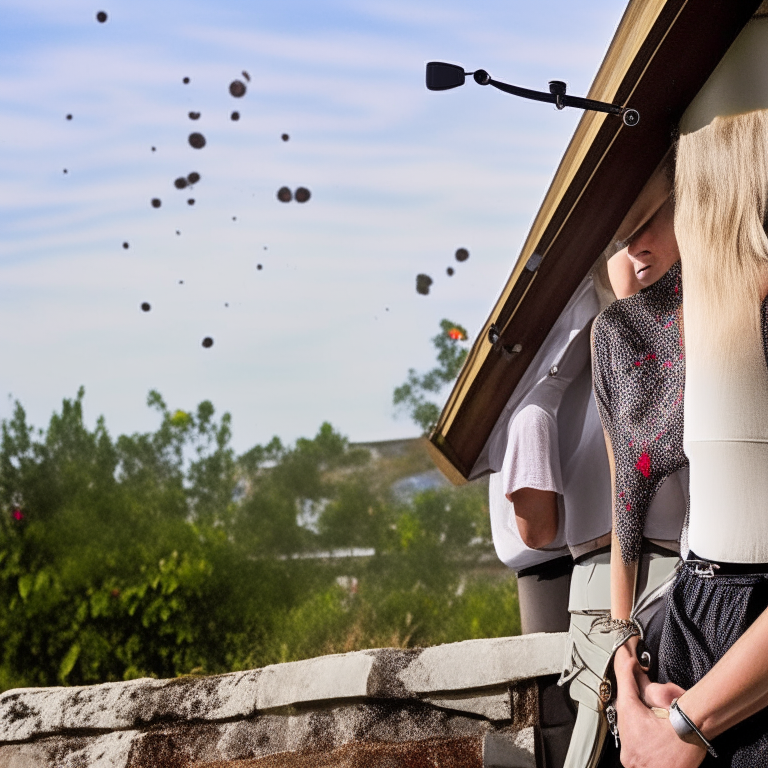

In [13]:
image

In [14]:
h = 768
w = 768
guidance_scale = 5.0
idxs = [290, 374]
# negs = False

all_embs = []
for i in idxs:
    image_embed = U[:, i:i+1].cuda().permute(1, 0)
    image_embed = image_embed * S[1].cuda() #** 0.5
    all_embs.append(image_embed)

image_embed = torch.cat(all_embs, dim=0).sum(0, keepdim=True) #/ len(idxs)
image_embed = image_embed + mean.cuda()

image = pipe(image_embeds=image_embed, 
            negative_image_embeds=prior_out.negative_image_embeds, 
            height=h, width=w, 
            num_inference_steps=25, guidance_scale=guidance_scale).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

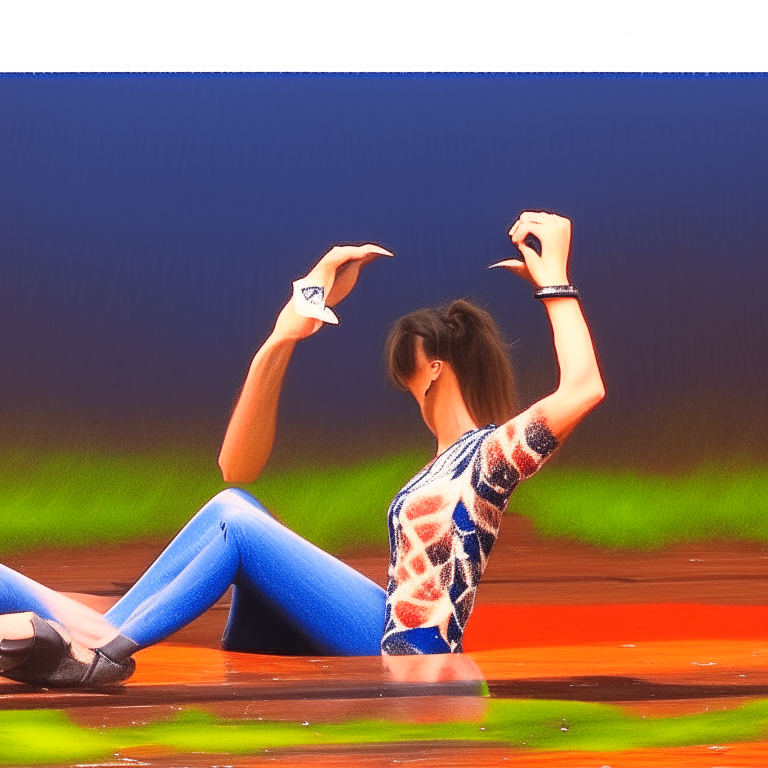

In [15]:
image

In [54]:

mediums = [
    "painting",
    "drawing",
    "photograph",
    "HD photo",
    "illustration",
    "portrait",
    "sketch",
    "3d render",
    "digital painting",
    "concept art",
    "screenshot",
]

subjects = [
    "dog",
    "cat",
    "car",
    "building",
    "house",
    "tree",
    "flower",
    "mountain",
    "lake",
    "person",
    "man",
    "woman",
    "toy",
    "horse",
    "bird",
    "soup",
    "chicken"
]

# target_word = "happy"
# opposite = "sad"

target_word = "artistic high quality"
opposite = "low quality, messy"

pipe_prior.set_progress_bar_config(disable=True)

with torch.no_grad():
    positives = []
    negatives = []
    for i in tqdm(range(100)):
        medium = random.choice(mediums)
        subject = random.choice(subjects)
        pos_prompt = f"a {medium} of a {target_word} {subject}"
        neg_prompt = f"a {medium} of a {opposite} {subject}"
        pos = pipe_prior(pos_prompt)
        neg = pipe_prior(neg_prompt)
        positives.append(pos.image_embeds)
        negatives.append(neg.image_embeds)
    

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


In [55]:
positives = torch.cat(positives, dim=0)
negatives = torch.cat(negatives, dim=0)

diffs = positives - negatives

avg_diff = diffs.mean(0, keepdim=True)

In [18]:
# logistic regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
    
    def forward(self, x):
        out = torch.sigmoid(self.linear(x))
        return out

clf = LogisticRegression(positives.shape[1], 1).cuda()
examples = torch.cat([positives, negatives], dim=0).float().cuda()
labels = torch.cat([torch.ones(positives.shape[0]), torch.zeros(negatives.shape[0])], dim=0)[:,None].cuda()
criteria = torch.nn.BCELoss()
optimizer = torch.optim.Adam(clf.parameters(), lr=0.01)

pbar = tqdm(range(1000))
for i in pbar:
    optimizer.zero_grad()
    out = clf(examples)
    loss = criteria(out, labels)
    loss.backward()
    optimizer.step()
    # if i % 50 == 0:
    #     print(loss)
    pbar.set_description(f"Loss: {loss.item()}")



Loss: 0.00011009124136762694: 100%|██████████| 1000/1000 [00:02<00:00, 444.39it/s]


In [19]:
learned_direction = clf.linear.weight.data.clone()

In [72]:
torch.manual_seed(7)
factor = 4.0

prompt = "A picture of a person"
prompt_embeds = pipe_prior(prompt)
neg_embeds = prompt_embeds.negative_image_embeds
prompt_embeds = prompt_embeds.image_embeds

prompt_embeds = prompt_embeds + avg_diff * factor

# prompt_embeds = prompt_embeds + learned_direction * factor

h = 1024
w = 1024
guidance_scale = 5.0
image = pipe(image_embeds=prompt_embeds, negative_image_embeds=neg_embeds, height=h, width=w, num_inference_steps=25, guidance_scale=guidance_scale).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

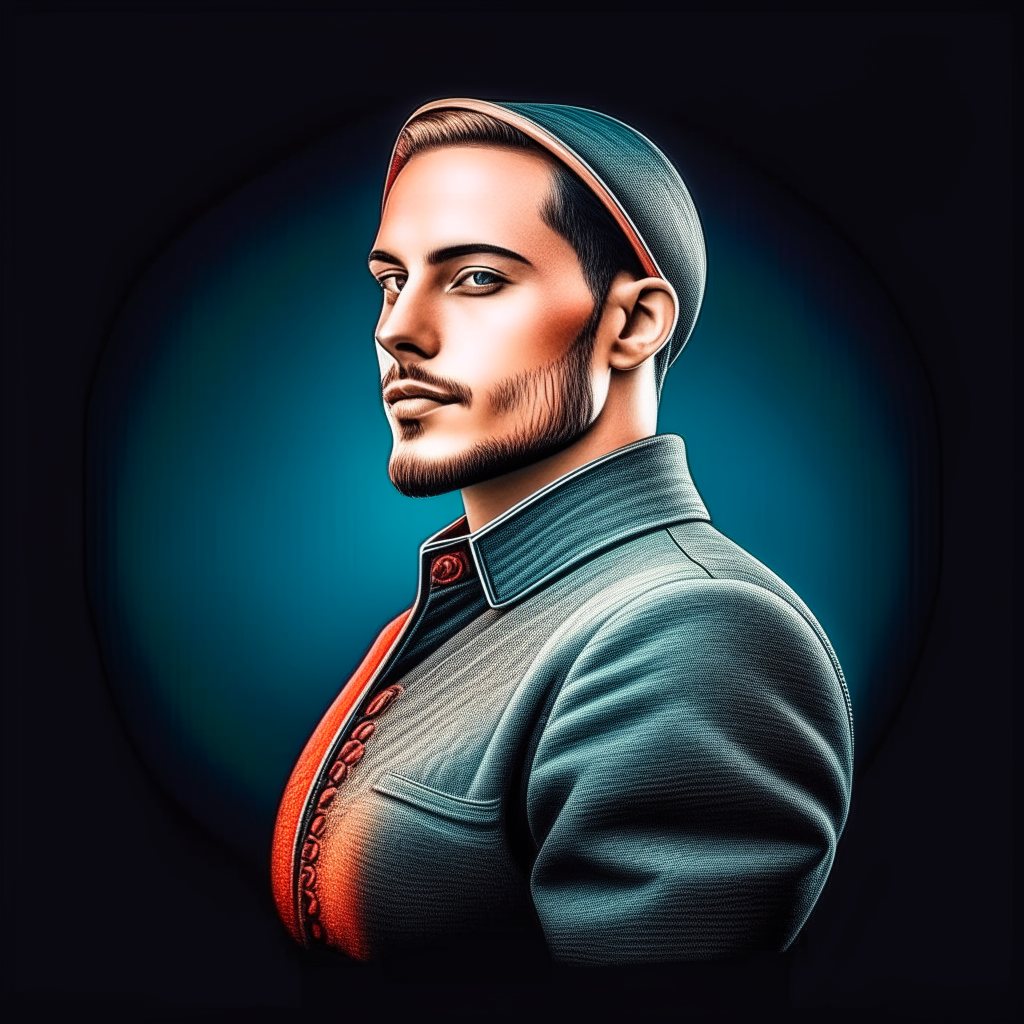

In [73]:
image

In [38]:
# from tqdm import tqdm

# min_value = torch.min(embeds)
# shifted_embeds = embeds - min_value

# def nmf_loss(data, basis_mat, coeff_mat, alpha=0.1):
#     reconstructed_data = torch.mm(basis_mat, coeff_mat)

#     # Non-negativity penalty
#     non_neg_penalty = alpha * (torch.sum(torch.min(basis_mat, torch.zeros_like(basis_mat))) +
#                                torch.sum(torch.min(coeff_mat, torch.zeros_like(coeff_mat))))

#     loss = torch.norm(data - reconstructed_data)

#     return loss + non_neg_penalty

# num_iterations = 1000
# learning_rate = 0.1
# rank = 32
# basis_matrix = torch.rand(shifted_embeds.shape[0], rank).cuda().requires_grad_(True)
# coeff_matrix = torch.rand(rank, shifted_embeds.shape[1]).cuda().requires_grad_(True)

# optimizer = torch.optim.Adam([basis_matrix, coeff_matrix], lr=learning_rate)

# # NMF optimization
# pbar = tqdm(range(num_iterations))
# for i in pbar:
#     optimizer.zero_grad()
#     loss = nmf_loss(shifted_embeds, basis_matrix, coeff_matrix)
#     loss.backward()
#     optimizer.step()
#     basis_matrix.data = torch.clamp(basis_matrix.data, 0)
#     coeff_matrix.data = torch.clamp(coeff_matrix.data, 0)
#     pbar.set_description(f"Loss: {loss.item()}")


# components = basis_matrix

Loss: 39060.19921875:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 13414.49609375: 100%|██████████| 1000/1000 [00:23<00:00, 41.73it/s] 
